In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
import matplotlib.cm as cm
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
# Set the paths for training and test data
train_data_dir = "training_data_path"
test_data_dir = "test_data_path"

In [4]:
# Define the labels
labels = ['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']

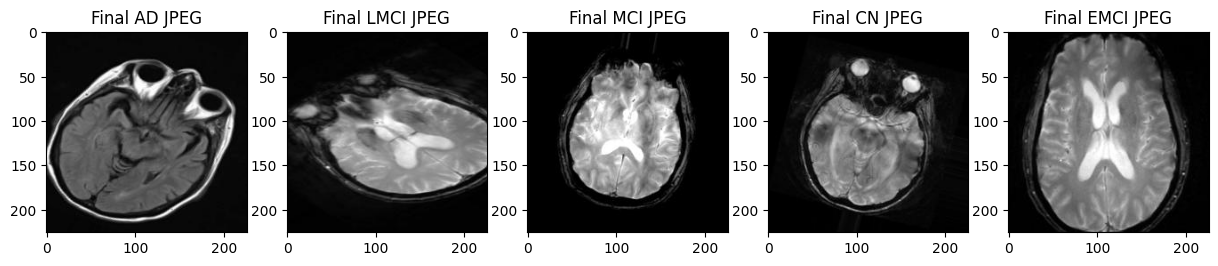

In [32]:
# Create a figure with 5 subplots in a row
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
# Loop through each label and load the first image from each label
for i, label in enumerate(labels):
    label_dir = os.path.join(train_data_dir, label)
    img_file = os.listdir(label_dir)[0]
    img_path = os.path.join(label_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert the image from BGR to RGB for visualization
    ax[i].imshow(img)
    ax[i].set_title(label)
plt.show()

In [5]:
# Load and preprocess the images for visualization
images = []
for label in labels:
    label_dir = os.path.join(train_data_dir, label)
    img_file = os.listdir(label_dir)[0]
    img_path = os.path.join(label_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB for visualization
    img = cv2.resize(img, (224, 224))  # Resize the image to the target size
    img = preprocess_input(img)  # Preprocess the image
    images.append(img)

In [6]:
# Utility function to display images with labels
def display_imgs_with_labels(images, labels):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 3))
    for i in range(len(images)):
        ax[i].imshow(images[i])
        ax[i].set_title(labels[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

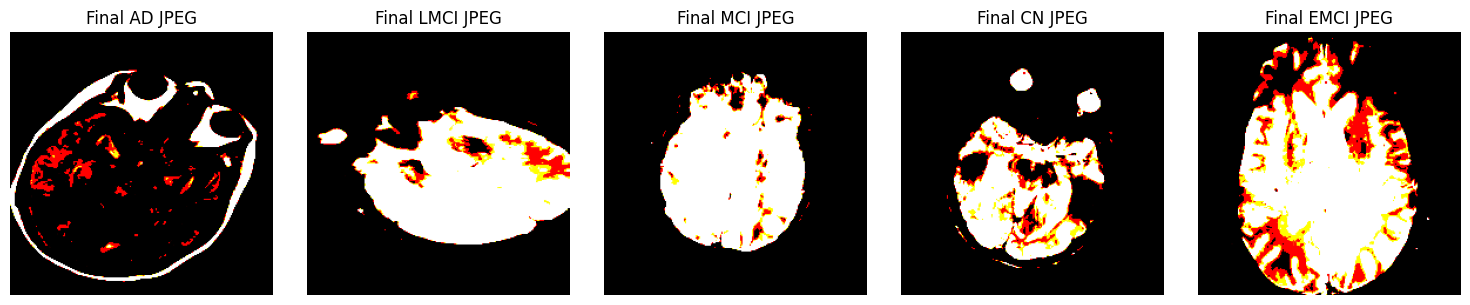

In [7]:
# Display the images with labels
display_imgs_with_labels(images, labels)

In [8]:
# Convert images to numpy array
input_images = np.array(images)

In [9]:
# Load and preprocess the entire dataset
X_train = []
y_train = []

In [10]:
image_size = 162
for label in labels:
    folder_directory = os.path.join(train_data_dir, label)
    for file_name in tqdm(os.listdir(folder_directory)):
        image = cv2.imread(os.path.join(folder_directory, file_name))
        image = cv2.resize(image, (image_size, image_size))
        image = preprocess_input(image)
        X_train.append(image)
        y_train.append(label)

100%|██████████| 1080/1080 [00:04<00:00, 220.24it/s]


In [11]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [13]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=101)

In [14]:
# Convert labels to categorical
y_train = to_categorical([labels.index(i) for i in y_train])
y_test = to_categorical([labels.index(i) for i in y_test])

In [15]:
# Create the VGG16 model
model = Model(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 6s 0us/step


In [16]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [17]:
# Define callbacks
tensorboard = TensorBoard(log_dir="logs")
checkpoint = ModelCheckpoint("model.h5",
                              monitor="val_accuracy", verbose=1,
                              mode="auto", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy",
                              factor=0.5,
                              patience=3, verbose=1,
                              mode="auto", min_delta=0.001)

In [19]:
# Get the input image index
image_index = 0

In [20]:
from tf_keras_vis.utils.scores import CategoricalScore

In [21]:
# Create score object for the selected class
score = CategoricalScore(image_index)

In [22]:
# Create GradCAM object
gradcam = Gradcam(model, clone=True)

In [23]:
# Generate heatmap with GradCAM
cam = gradcam(score, input_images, penultimate_layer=-1)

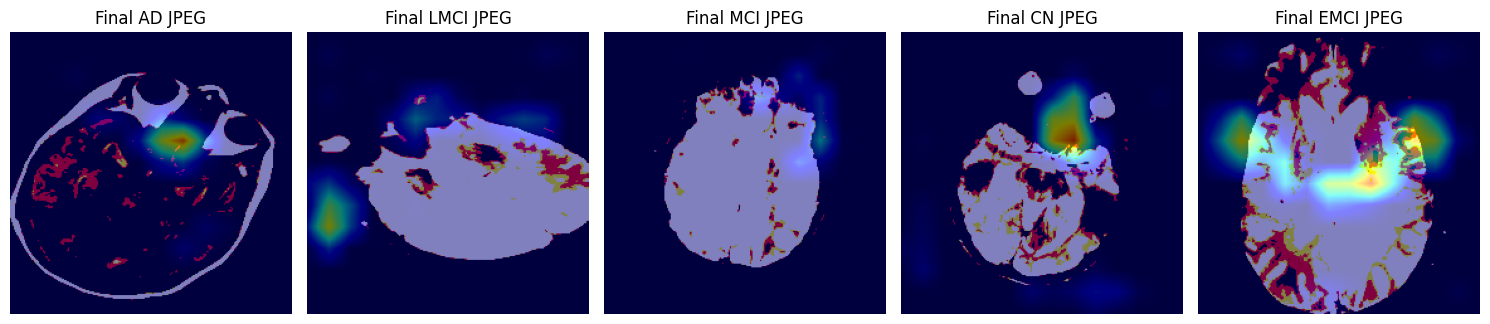

In [24]:
# Show generated images with heatmap
f, ax = plt.subplots(nrows=1, ncols=len(input_images), figsize=(15, 4))
for i in range(len(input_images)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].imshow(input_images[i])
    ax[i].set_title(labels[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [25]:
from tf_keras_vis.saliency import Saliency

In [26]:
# Create Saliency object
saliency = Saliency(model, clone=False)

In [28]:
from tf_keras_vis.utils import normalize

In [29]:
# Generate saliency map
saliency_map = saliency(score, input_images)
saliency_map = normalize(saliency_map)

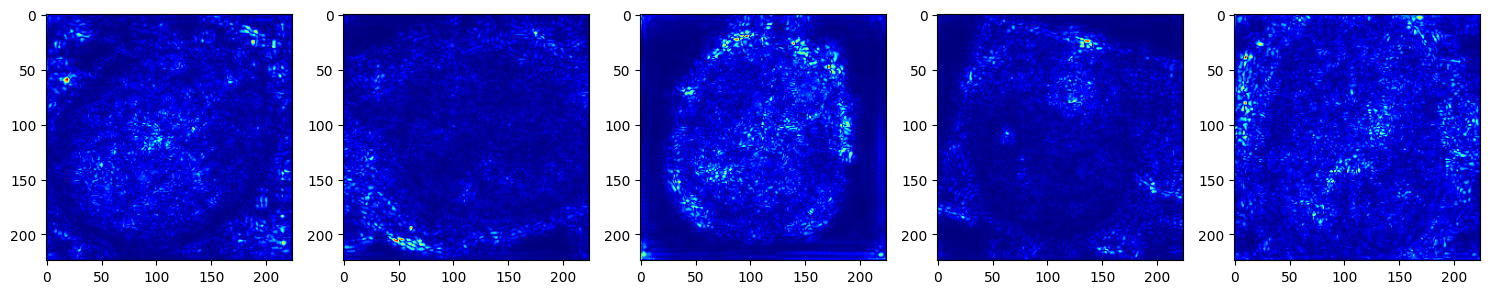

In [30]:
# Display saliency maps
f, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 4))
for i in range(len(saliency_map)):
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()